In [171]:
import os

import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader, random_split
from torch.optim import Adam
from torch.distributions import MultivariateNormal, Normal
from torchvision.transforms import ToTensor

from PIL import Image
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [172]:
from torch.utils.tensorboard import SummaryWriter
%load_ext tensorboard

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


# Get data

In [173]:
#DEVICE = 'cpu'
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')


In [174]:
DATAPATH = 'C:/Users/matan/Documents/data/coil-20-proc'
root_dir = DATAPATH + '/coil-20-proc'
csv_file = 'C:/Users/matan/Documents/data/coil-20-proc/labels.csv'

In [175]:
df = pd.read_csv(csv_file)

In [176]:
class COIL20(Dataset):
    def __init__(self, root_dir, csv_file, transform=None):
        self.df = pd.read_csv(csv_file)
        self.transform = transform
        self.root_dir = root_dir

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        row = self.df.loc[idx]
        img_id, img_label = row['image'], row['label']
        img_filename = self.root_dir + '/' + str(img_id)
        img = Image.open(img_filename)
        if self.transform:
            img = self.transform(img)
        return img, img_label

Number of images in the dataset:  1440
Image shape: torch.Size([1, 128, 128])


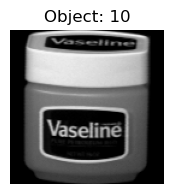

In [177]:
dataset = COIL20(root_dir, csv_file, transform=ToTensor())
print("Number of images in the dataset: ", len(dataset))
img, label = dataset[0]
print("Image shape:", img.shape)

plt.figure(figsize=(2,2))
plt.imshow(img.permute(1,2,0), cmap=plt.get_cmap('gray'))
plt.title("Object: " + str(label))
plt.axis('off')
plt.show()

In [178]:
# Hyperparameters
batch_size = 32
lr = 0.001

N = len(dataset)
in_channels = 1
input_size = [in_channels, 128, 128]
dim_input = np.prod(input_size)
dim_hidden = 1024
dim_latent = 256
n_classes = 20
seed = 11       # Random seed for reproducible results
torch.manual_seed(seed);

In [179]:
test_size = int(0.1*N)
val_size = int(0.1*N)
train_size = N - test_size - val_size

train_data, val_data, test_data = random_split(dataset, [train_size, val_size, test_size])
print("Training images: ", len(train_data))
print("Validation images: ", len(val_data))
print("Test images: ", len(test_data))

#kwargs = {'num_workers': 1, 'pin_memory': True} 
kwargs = {}
train_loader = DataLoader(train_data, batch_size, shuffle=True, **kwargs)
test_loader = DataLoader(test_data, len(test_data), **kwargs)
val_loader = DataLoader(val_data, len(val_data), **kwargs)

Training images:  1152
Validation images:  144
Test images:  144


In [180]:
def show_batch(dl):
    for images, labels in dl:
        fig, ax = plt.subplots(figsize=(12, 6))
        ax.set_xticks([]); ax.set_yticks([])
        ax.imshow(make_grid(images, nrow=16).permute(1, 2, 0))
        break


# Make and train VAE model

In [181]:
class Encoder(nn.Module):
    def __init__(self, dim_input, dim_hidden, dim_latent):
        super(Encoder, self).__init__()
        self.fc1 = nn.Linear(dim_input, dim_hidden)
        self.fc2 = nn.Linear(dim_hidden, dim_hidden)
        self.mu = nn.Linear(dim_hidden, dim_latent)
        self.var = nn.Linear(dim_hidden, dim_latent)

        self.activation = nn.LeakyReLU(0.2) #nn.Tanh()
    
    def forward(self, x):
        x = torch.flatten(x, start_dim=1)   # Flatten image
        h1 = self.activation(self.fc1(x))
        h1 = self.activation(self.fc2(h1))
        return self.mu(h1), self.var(h1)


class Decoder(nn.Module):
    def __init__(self, dim_latent, dim_hidden, dim_input):
        super(Decoder, self).__init__()
        self.fc1 = nn.Linear(dim_latent, dim_hidden)
        self.fc2 = nn.Linear(dim_hidden, dim_hidden)
        self.fc3 = nn.Linear(dim_hidden, dim_input)
        self.activation = nn.LeakyReLU(0.2) #nn.Tanh()

    def forward(self, z):
        h1 = self.activation(self.fc1(z))
        h1 = self.activation(self.fc2(h1))
        #return self.mu(h1), self.var(h1)
        return torch.tanh(self.fc3(h1))


class Model(nn.Module):
    def __init__(self, Encoder, Decoder):
        super(Model, self).__init__()
        self.Encoder = Encoder
        self.Decoder = Decoder

    def reparametrization(self, mean, var):
        eps = torch.randn_like(var).to(DEVICE) # Ransom tensor in same shape as var
        z = mean + var*eps
        return z

    def forward(self, x):
        mean, log_var = self.Encoder(x)
        std = torch.exp(0.5 * log_var)
        z = self.reparametrization(mean, std)
        x_hat = self.Decoder(z)
        return x_hat, mean, log_var


def loss_function(x, out, mean, log_var, alpha = 0.01):
    """
    Loss function for the model
    """
    x_hat=out
    reproduction_loss = nn.functional.mse_loss(x_hat, x)
    KL_divergence = -0.5 * torch.sum(1 + log_var - mean.pow(2) - log_var.exp())
    print("Loss:", (1-alpha)*reproduction_loss, KL_divergence*alpha)
    return (1-alpha)*reproduction_loss + KL_divergence*alpha

In [182]:
encoder = Encoder(dim_input, dim_hidden, dim_latent).to(DEVICE)
decoder = Decoder(dim_latent, dim_hidden, dim_input).to(DEVICE)
model = Model(encoder, decoder).to(DEVICE)
optimizer = Adam(model.parameters(), lr=lr)
print(DEVICE)

cuda


In [183]:
# Train the model
epochs = 30
loss_per_epoch = []
validation_loss = []
for epoch in range(epochs):
    model.train()
    loss_this_epoch = 0
    for batch, (x, label) in enumerate(train_loader):
        x = x.to(DEVICE)
        x = torch.flatten(x, start_dim=1)

        assert not torch.isnan(x).any()
        optimizer.zero_grad()

        out, q_mean, q_log_var = model(x)
        x_hat = out

        if torch.isnan(x_hat.view(-1)).sum().item() != 0:
            print("Number of nans:", torch.isnan(x_hat.view(-1)).sum().item())
            print(x_hat)
        assert not torch.isnan(x_hat).any()
        
        loss = loss_function(x, out, q_mean, q_log_var)
        loss_this_epoch += loss.item() 

        loss.backward()
        optimizer.step()
        
    loss_per_epoch.append(loss_this_epoch / ((batch+1)*batch_size))
    print("\tEpoch", epoch + 1, "complete!", "\tAverage Loss: ", loss_this_epoch / ((batch+1)*batch_size))

    # model.eval()
    # with torch.no_grad():
    #     x_hat, q_mean, q_log_var = model(val_data)
    #     loss = loss_function(val_data, x_hat, q_mean, q_log_var)
    #     validation_loss.append(loss.item() / len(val_data))

Loss: tensor(0.2163, device='cuda:0', grad_fn=<MulBackward0>) tensor(0.1550, device='cuda:0', grad_fn=<MulBackward0>)
Loss: tensor(0.1616, device='cuda:0', grad_fn=<MulBackward0>) tensor(35.2859, device='cuda:0', grad_fn=<MulBackward0>)
Loss: tensor(0.1580, device='cuda:0', grad_fn=<MulBackward0>) tensor(51.7821, device='cuda:0', grad_fn=<MulBackward0>)
Loss: tensor(0.1102, device='cuda:0', grad_fn=<MulBackward0>) tensor(11.7683, device='cuda:0', grad_fn=<MulBackward0>)
Loss: tensor(0.1043, device='cuda:0', grad_fn=<MulBackward0>) tensor(21.0477, device='cuda:0', grad_fn=<MulBackward0>)
Loss: tensor(0.0998, device='cuda:0', grad_fn=<MulBackward0>) tensor(8.1979, device='cuda:0', grad_fn=<MulBackward0>)
Loss: tensor(0.1021, device='cuda:0', grad_fn=<MulBackward0>) tensor(5.6548, device='cuda:0', grad_fn=<MulBackward0>)
Loss: tensor(0.0822, device='cuda:0', grad_fn=<MulBackward0>) tensor(3.8237, device='cuda:0', grad_fn=<MulBackward0>)
Loss: tensor(0.0781, device='cuda:0', grad_fn=<MulBa

Text(0.5, 0, 'Epoch')

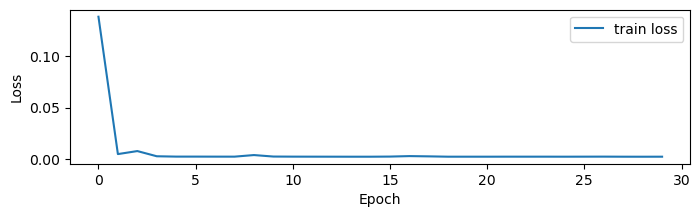

In [184]:
plt.figure(figsize=(8,2))
plt.plot(range(epochs), loss_per_epoch, label = "train loss")
#plt.plot(range(epochs), validation_loss, label = 'validation_loss')
plt.legend()
plt.ylabel("Loss")
plt.xlabel("Epoch")

# Evaluate the model

<Figure size 400x200 with 0 Axes>

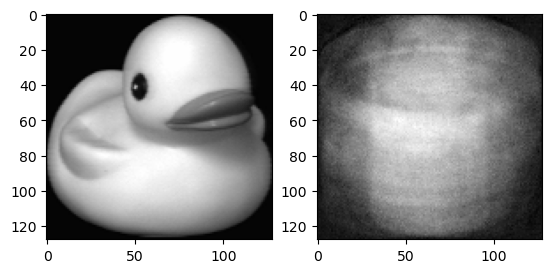

In [185]:
model.eval()

# See reconstruction of an image in the training set
img, label = train_data[900]
img_repro, _, _ = model(img.to(DEVICE))
img_repro = img_repro.reshape((1,128,128)).cpu().detach()
plt.figure(figsize=(4,2))
fig, axs = plt.subplots(1,2)
axs[0].imshow(img.permute(1,2,0), cmap=plt.get_cmap('gray'))
axs[1].imshow(img_repro.permute(1,2,0), cmap=plt.get_cmap('gray'))